# 用Bokeh创建静态动画

所谓静态动画是指动画一旦创建就再也不与Python内核相关，所有的动画数据都在图表创建时作为JSON数据传递给客户端处理。动画效果由Javascript程序实现。

In [12]:
from bokehelp import output_notebook, show_figure
#from bokeh.io import output_notebook #如果希望从CDN载入bokeh.js，则取消该行注释
from bokeh.plotting import Figure
from bokeh.models import ColumnDataSource

output_notebook()

Loading BokehJS ...

## 显示图表之后调用Javascript程序

Bokeh没有提供输出用户自定义的Javascript程序的功能，因此只能通过分析Bokeh的源代码，找到可以注入Javascript程序的方法。下面是一个简单的例子。它在输出图表之后，调用Javascript的函数设置图表中的曲线数据。

{1}使用jinja2模板生成Javascript代码`jscode`，{2}在显示图表之前，把`bokeh.embed.EMPTY`修改为`JS_RAW`对象，Bokeh在输出图表时，会将`EMPTY.js_raw`中的代码输出。{3}完成图表显示之后，将`EMPTY`还原为原来的值。

{4}由于`EMPTY.js_raw`中的Javascript程序在图表生成之前调用，因此这里使用`setTimeout()`延迟运行修改图表显示的代码。

{5}Bokeh的每个Python对象都有`_id`属性，通过该属性可以获得其在Javascript中对应的对象。例如:`Bokeh.index[fig_id]`获得`Figure`对象。{6}`fig.model.document`获得图表对应的`Document`对象。{7}通过`Document.get_model_by_id()`可以获得`Document`中指定ID对应的模型对象。例如这里获得与Python中的`source`对应的对象。修改了`ColumnDataSource`对象中的数据之后，调用其`trigger('change')`触发图表的重绘。

In [16]:
from bokeh import embed, resources
from jinja2 import Template

fig = Figure(plot_height=300)
source = ColumnDataSource(data=dict(x=[], y=[]))
line = fig.line("x", "y", source=source)

jscode = Template("""
setTimeout(                                                  //{4}
    function(){
        var fig = Bokeh.index['{{fig._id}}'];                //{5}
        var doc = fig.model.document;                        //{6}
        var source = doc.get_model_by_id('{{source._id}}');  //{7}
        var data = source.get('data');                       //{8} 
        for(i=0;i<100;i++){
            var x = i * 0.1;
            data.x.push(x);
            data.y.push(Math.sin(x));
        }
        source.trigger('change');                            //{9}
    }, 
    10
);
""").render(fig=fig, source=source)  #{1}

class JS_RAW:
    def __init__(self, jscode):
        self.js_raw = [jscode]
    
    def __getattr__(self, name):
        return []

embed.EMPTY = JS_RAW(jscode) #{2}
show_figure(fig)
embed.EMPTY = resources.EMPTY #{3}

为了方便使用，我们使用`show_figure_with_callback()`包装上述的方法。它的调用形式为`show_figure_with_callback(fig, callback, **kw)`。其中:

* `fig`:Bokeh中的`Figure`对象。

* `callback`:Python的函数，在`show_figure_with_callback()`内部会通过Flexx扩展库提供的`py2js()`将该函数转换为Javascript的函数。在该函数中可以通过`fig`和`doc`访问Javascript中与`Figure`和`Document`对应的对象。

* `**kw`:传递给`callback`的参数。可以传递的对象有两种：

 * `Bokeh.models`中定义的模型对象。
 * 表示JSON数据的字符串。
 
 在下面的例子中，`callback()`有三个参数`source`, `x_data`和`y_data`。当调用其转换之后的Javascript函数时，`source`参数对应的是`ColumnDataSource`对象，而`x_data`和`y_data`对应的是表示数据的数组对象。为了将数组数据传递给该函数，调用`show_figure_with_callback()`时，使用`json.dumps()`将列表转换为字符串。

In [3]:
from bokehelp import show_figure_with_callback
import numpy as np
import json

x = np.linspace(0, 4*np.pi, 100)
y = np.sin(x)

def callback(source, x_data, y_data):
    data = source.get('data')
    data.x = x_data
    data.y = y_data
    source.trigger("change")

fig = Figure(plot_height=300)
source = ColumnDataSource(data=dict(x=[], y=[]))
line = fig.line("x", "y", source=source)

show_figure_with_callback(fig, callback, source=source, 
                          x_data=json.dumps(x.tolist()),
                          y_data=json.dumps(y.tolist()))

## 多体运动模拟动画

最后让我们用`show_figure_with_callback()`制作一个多体运动的模拟动画。下面是计算多体运动轨迹程序，`data`是表示每个质点位置的数组，`json_data`是将该数组对应的JSON字符串。数组的形状为(轨迹的长度，X-Y轴，质点数)。因此`data[:, 0, 0]`为第一个质点运动轨迹的X轴坐标。

> 多体运动的模拟涉及到常微分方程的数值求解。请感兴趣的读者阅读《Python科学计算》一书的相关章节。

In [4]:
import numpy as np
import json
from scipy import integrate

N = 5

status = np.r_[np.random.randn(N), np.random.randn(N), np.zeros(N), np.zeros(N)]
x, y, vx, vy = status.reshape(-1, N)

def f(status, t):
    x, y, vx, vy = status.reshape(-1, N)
    X = x - x[:, None]
    Y = y - y[:, None]
    D = X**2 + Y**2    
    ax = np.nansum(X/D, axis=1)
    ay = np.nansum(Y/D, axis=1)
    return np.r_[vx, vy, ax, ay]

t = np.arange(0, 10, 0.02)
r = integrate.odeint(f, status, t)
data = r.reshape(-1, 4, N)[:, :2, :]
json_data = json.dumps(data.tolist())
print(data.shape)

(500, 2, 5)


下面先使用`matplotlib`显示`data`表示的运动轨迹。

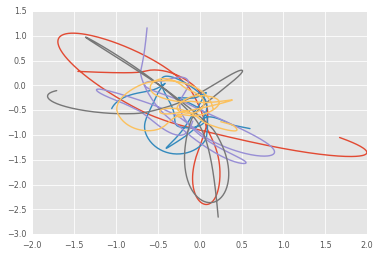

In [11]:
%matplotlib inline
import pylab as pl
pl.style.use("ggplot")

for i in range(N):
    pl.plot(data[:, 0, i], data[:, 1, i])

下面使用`show_figure_with_callback()`用动画显示轨迹数据。质点使用`fig.circle()`绘制，而质点对应轨迹使用`fig.multi_line()`绘制。本例中使用了两个`ColumnDataSource`对象:

* `source`: 其中的`x`和`y`为长度为`N`的一维数组，表示质点的坐标。
* `track_source`: 其中的`x`和`y`是形状为(N, 20)的二维数组，它表示多个质点的运动轨迹，其中20为轨迹残留长度。

`animate()`对应的Javascript程序运行之后，{1}调用`setInterval()`设置每10ms运行一次`callback()`函数。在`callback()`函数中，更新上述两个`ColumnDataSource`对象中的数据，并重绘图表。{2}为图表设置点击事件响应函数，但用户同时按住Ctrl和Shift按键，并点击图表时，动画将从头开始播放。这里`fig`是Javascript表示图表的对象，`fig[$el]`是与图表对应的JQuery对象。可是使用JQuery提供的各种功能对其进行处理。这里通过`click()`方法为其添加点击事件响应函数。

In [13]:
cx, cy = np.mean(data, axis=(0, 2))
fig = Figure(x_range=(cx-2, cx+2), y_range=(-2, 2), plot_width=500, plot_height=500)
source = ColumnDataSource(data={"x":data[0][0], "y":data[0][1]})
track_source = ColumnDataSource(data={"x":[[0]], "y":[[0]]})
colors = ["red", "green", "blue", "yellow", "black"]
fig.circle(x="x", y="y", source=source, size=10, color=colors)
fig.multi_line(xs="x", ys="y", source=track_source, color=colors)

def animate(source, track_source, json_data):
    data = source.get('data')
    track_data = track_source.get('data')
    idx = 0
    n = len(json_data[0][0])
    track_x = [[] for _ in range(n)]
    track_y = [[] for _ in range(n)]

    def callback():
        nonlocal idx
        data.x = json_data[idx][0]
        data.y = json_data[idx][1]
    
        for i in range(n):
            track_x[i].append(data.x[i])
            track_y[i].append(data.y[i])
            
            if len(track_x[i]) > 20:
                track_x[i].pop(0)
                track_y[i].pop(0)
        
        track_data.x = track_x
        track_data.y = track_y
        
        source.trigger("change")
        track_source.trigger("change")
        
        idx += 1
        if idx == len(json_data):
            window.clearInterval(tid)
            
    tid = window.setInterval(callback, 10) #{1}
    
    def reset(evt):
        nonlocal idx, tid, track_x, track_y
        if not evt.shiftKey or not evt.ctrlKey:
            return
        print(evt)
        window.clearInterval(tid)
        tid = window.setInterval(callback, 10)
        idx = 0
        track_x = [[] for _ in range(n)]
        track_y = [[] for _ in range(n)]
        
    fig["$el"].click(reset) #{2}
    
show_figure_with_callback(fig, animate, source=source, track_source=track_source, json_data=json_data)